# Import Library

In [ ]:
import tensorflow as tf
import time
import tensorflow_datasets as tfds
import tensorflow_hub as hub

In [ ]:
import os
import json
import zipfile
import random
import numpy as np
import seaborn as sns
import tifffile as tiff
import cv2
from pycocotools.coco import COCO
from functools import partial
import matplotlib.pyplot as plt
import albumentations as A
import rasterio
from rasterio.transform import from_origin
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, Input, optimizers, losses, metrics
from tensorflow.keras.layers import Input, Dropout, Attention, Lambda, SpatialDropout2D
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape, Multiply
from tensorflow.keras.layers import Conv2D, GlobalMaxPooling2D, Add, Activation, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from collections import defaultdict
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Add 

/home/ailaboratory/.pyenv/versions/3.10.12/lib/python3.10/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Import Data

# Load Data

In [ ]:
# LOAD COCO

def load_coco_annotations(annotation_file):
    coco = COCO(annotation_file)
    used_category_ids = set()
    for img_id in coco.getImgIds():
        ann_ids = coco.getAnnIds(imgIds=img_id)
        anns = coco.loadAnns(ann_ids)
        used_category_ids.update(ann['category_id'] for ann in anns)
    valid_category_ids = sorted(list(used_category_ids))
    category_dict_coco_original_name_to_new_dense_idx = {
        coco.loadCats(cat_id)[0]['name']: idx for idx, cat_id in enumerate(valid_category_ids)
    }
    return coco, category_dict_coco_original_name_to_new_dense_idx

# Preprocess

In [ ]:
def coco_to_multiclass_mask(coco, image_id, image_size, selected_classes_list, coco_name_to_original_dense_idx_map):
    height, width = image_size
    final_mask = np.zeros((height, width), dtype=np.uint8)

    ann_ids = coco.getAnnIds(imgIds=[image_id])
    anns = coco.loadAnns(ann_ids)

    for ann in anns:
        category_id_coco = ann["category_id"]
        category_name_coco = coco.loadCats([category_id_coco])[0]["name"]
        if category_name_coco in selected_classes_list:
            target_class_id = selected_classes_list.index(category_name_coco) + 1
            
            segmentation = coco.annToMask(ann)
            if segmentation.shape[0] != height or segmentation.shape[1] != width:
                segmentation = cv2.resize(segmentation, (width, height), interpolation=cv2.INTER_NEAREST)
            
            final_mask[segmentation == 1] = target_class_id
            
    return final_mask

In [ ]:
def save_singlelayer_tiff(array, filename):
    if array.ndim != 2: 
        raise ValueError("Input array must be 2D with shape (H, W)")

    height, width = array.shape
    transform = from_origin(0, 0, 1, 1)
    metadata = {
        "driver": "GTiff",
        "height": height,
        "width": width,
        "count": 1, 
        "dtype": array.dtype,
        "crs": None,
        "transform": transform
    }
    with rasterio.open(filename, "w", **metadata) as dst:
        dst.write(array, 1)

In [ ]:
def process_dataset_to_multiclass_tiff(annotation_file, output_folder, selected_classes_list_for_masking):
    os.makedirs(output_folder, exist_ok=True)
    coco, _ = load_coco_annotations(annotation_file)

    print(f"Target classes for mask generation: {selected_classes_list_for_masking}")
    for img_info in coco.dataset["images"]:
        image_id = img_info["id"]
        file_name = img_info["file_name"]
        image_size = (img_info["height"], img_info["width"])

        mask_hw = coco_to_multiclass_mask(coco, image_id, image_size, selected_classes_list_for_masking, _) 
        
        output_path = os.path.join(output_folder, file_name.replace(".jpg", ".tiff").replace(".png", ".tiff").replace(".jpeg", ".tiff"))
        save_singlelayer_tiff(mask_hw, output_path)
    print("Finished processing dataset to Multi-Class TIFFs.")

In [ ]:
# scan-gizi-makan-coba-3-classes
coco, dictclass = load_coco_annotations("./datasetmakanan/train/_annotations.coco.json")
print(dictclass)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
{'ayam_goreng': 0, 'nasi': 1, 'rendang': 2, 'sayur_kangkung': 3, 'sayursop': 4, 'tahu_goreng': 5, 'telur_dadar': 6, 'tempe_goreng': 7}


# SET APA GITU

In [ ]:
ANNOTATION_FILE_TRAIN = "./datasetmakanan/train/_annotations.coco.json"
IMAGE_FOLDER_TRAIN = "./datasetmakanan/train/"
MASK_OUTPUT_FOLDER_TRAIN = "./datasetmakanan/mask_multiclass_tf"

In [14]:
SELECTED_CLASSES = ['nasi', 'ayam_goreng', 'rendang', 'sayur_kangkung', 'sayursop', 'telur_dadar']
NUM_MODEL_CLASSES = len(SELECTED_CLASSES) + 1
TARGET_SIZE = (320, 320)
BATCH_SIZE = 8
GROUPS_FOR_GN = 16

# Data Splitting

In [15]:
print(f"Generating Multi-Class masks for {len(SELECTED_CLASSES)} foreground classes...")
process_dataset_to_multiclass_tiff(ANNOTATION_FILE_TRAIN, MASK_OUTPUT_FOLDER_TRAIN, SELECTED_CLASSES)

Generating Multi-Class masks for 6 foreground classes...
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Target classes for mask generation: ['nasi', 'ayam_goreng', 'rendang', 'sayur_kangkung', 'sayursop', 'telur_dadar']


/home/ailaboratory/.pyenv/versions/3.10.12/lib/python3.10/site-packages/rasterio/__init__.py:366: NotGeoreferencedWarning: The given matrix is equal to Affine.identity or its flipped counterpart. GDAL may ignore this matrix and save no geotransform without raising an error. This behavior is somewhat driver-specific.
  dataset = writer(


Finished processing dataset to Multi-Class TIFFs.


In [17]:
image_files = sorted([f for f in os.listdir(IMAGE_FOLDER_TRAIN) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files_mc = sorted([f for f in os.listdir(MASK_OUTPUT_FOLDER_TRAIN) if f.endswith('.tiff')])

In [19]:
image_mask_pairs_mc = []
for img_name in image_files:
    mask_name = img_name.rsplit('.', 1)[0] + ".tiff"
    if mask_name in mask_files_mc: # Gunakan mask_files_mc
        mask_path = os.path.join(MASK_OUTPUT_FOLDER_TRAIN, mask_name)
        try:
            mask_content_hw = tiff.imread(mask_path) 
            
            if np.any(mask_content_hw > 0): 
                image_mask_pairs_mc.append((os.path.join(IMAGE_FOLDER_TRAIN, img_name), mask_path))
            else:
                print(f"Mask {mask_name} only contains background. Skipping.")
        except Exception as e:
            print(f"Error reading or processing mask {mask_path} for emptiness check: {e}")

print(f"Found {len(image_mask_pairs_mc)} valid image-mask pairs (with foreground objects).")

Mask FG_tempegorengv2_100_jpg.rf.740e593769ab171b4ba2b8bf6da1350a.tiff only contains background. Skipping.
Mask FG_tempegorengv2_101_jpg.rf.3c82ed60b121bb5bf7a7c05e57cea4ae.tiff only contains background. Skipping.
Mask FG_tempegorengv2_102_jpg.rf.c99168096da9dce291d1ae254dc149d5.tiff only contains background. Skipping.
Mask FG_tempegorengv2_103_jpg.rf.9db54443e62de6d6ca20be3b57dfe13a.tiff only contains background. Skipping.
Mask FG_tempegorengv2_104_jpg.rf.04c78819f5f110bccb6b1bccd0929380.tiff only contains background. Skipping.
Mask FG_tempegorengv2_105_jpg.rf.25ec8b91e5c936721f73e8acac9c9f82.tiff only contains background. Skipping.
Mask FG_tempegorengv2_106_jpg.rf.cff235f6040d6b1298777b9f8c255448.tiff only contains background. Skipping.
Mask FG_tempegorengv2_107_jpg.rf.4d94af69e513a28d56574680f6d74c48.tiff only contains background. Skipping.
Mask FG_tempegorengv2_108_jpg.rf.d52a928acca2105bd594e607a1d33761.tiff only contains background. Skipping.
Mask FG_tempegorengv2_109_jpg.rf.312f

In [20]:
if not image_mask_pairs_mc:
    raise ValueError("No image-mask pairs found. Check mask generation and paths.")

train_val_pairs_mc, test_pairs_mc = train_test_split(image_mask_pairs_mc, test_size=0.2, random_state=42)
train_pairs_mc, val_pairs_mc = train_test_split(train_val_pairs_mc, test_size=0.25, random_state=42)

train_image_paths_mc, train_mask_paths_mc = zip(*train_pairs_mc)
val_image_paths_mc, val_mask_paths_mc = zip(*val_pairs_mc)
test_image_paths_mc, test_mask_paths_mc = zip(*test_pairs_mc)

In [23]:
train_image_paths_mc = np.array(list(train_image_paths_mc), dtype=str)
train_mask_paths_mc = np.array(list(train_mask_paths_mc), dtype=str)
val_image_paths_mc = np.array(list(val_image_paths_mc), dtype=str)
val_mask_paths_mc = np.array(list(val_mask_paths_mc), dtype=str)
test_image_paths_mc = np.array(list(test_image_paths_mc), dtype=str)
test_mask_paths_mc = np.array(list(test_mask_paths_mc), dtype=str)

In [ ]:
def load_image(image_path):
    image = cv2.imread(image_path.decode()) 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, TARGET_SIZE)  
    image = image / 255.0  
    return image.astype(np.float32)

def load_mask_multiclass(mask_path_str_tensor):
    mask_path = mask_path_str_tensor.decode() 
    mask_hw = tiff.imread(mask_path) 
    
    mask_hw_resized = cv2.resize(mask_hw, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_NEAREST)
    
    return mask_hw_resized.astype(np.int32)

In [25]:
crop_height_min = int(TARGET_SIZE[0] * 0.8)
crop_width_min = int(TARGET_SIZE[1] * 0.8)

## Augmentasi

In [ ]:
albumentations_transform_baseline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5, interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=5, val_shift_limit=5, p=0.3),
    A.RandomCrop(width=crop_width_min, height=crop_height_min, p=0.5), 
    A.RandomResizedCrop(
                        size=TARGET_SIZE,
                        scale=(0.8, 1.0), ratio=(0.75, 1.33), 
                        interpolation=cv2.INTER_LINEAR, 
                        always_apply=False, p=0.5),
    A.MedianBlur(blur_limit=(3, 7), p=0.3),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.3),
    A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1], 
             interpolation=cv2.INTER_LINEAR, 
             always_apply=True) 
])

/tmp/ipykernel_2267911/3609351120.py:3: UserWarning: Argument(s) 'value, mask_value' are not valid for transform Rotate
  A.Rotate(limit=15, p=0.5, interpolation=cv2.INTER_NEAREST, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0),
/tmp/ipykernel_2267911/3609351120.py:7: UserWarning: Argument(s) 'always_apply' are not valid for transform RandomResizedCrop
  A.RandomResizedCrop(
/tmp/ipykernel_2267911/3609351120.py:14: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=TARGET_SIZE[0], width=TARGET_SIZE[1],


### Cutmix

In [ ]:
def generate_cutmix_bounding_box(img_shape_tuple, lam_val): 
    img_h, img_w = img_shape_tuple[0], img_shape_tuple[1]
    
    cut_ratio = tf.sqrt(1. - lam_val) 
    cut_w = tf.cast(tf.cast(img_w, tf.float32) * cut_ratio, tf.int32)
    cut_h = tf.cast(tf.cast(img_h, tf.float32) * cut_ratio, tf.int32)

    cx = tf.random.uniform(shape=[], minval=0, maxval=img_w, dtype=tf.int32)
    cy = tf.random.uniform(shape=[], minval=0, maxval=img_h, dtype=tf.int32)

    bbx1 = tf.clip_by_value(cx - cut_w // 2, 0, img_w)
    bby1 = tf.clip_by_value(cy - cut_h // 2, 0, img_h)
    bbx2 = tf.clip_by_value(cx + cut_w // 2, 0, img_w)
    bby2 = tf.clip_by_value(cy + cut_h // 2, 0, img_h)
    
    actual_cut_w = bbx2 - bbx1
    actual_cut_h = bby2 - bby1
    
    new_lam = 1. - (tf.cast(actual_cut_w * actual_cut_h, tf.float32) / 
                    tf.cast(img_w * img_h, tf.float32))
    
    return bbx1, bby1, bbx2, bby2, new_lam

In [ ]:
@tf.function
def cutmix_batch_tf_with_tensorarray(images_batch, masks_batch, alpha_py_float=1.0):
    batch_size = tf.shape(images_batch)[0]
    img_h_static = TARGET_SIZE[0]
    img_w_static = TARGET_SIZE[1]
    num_channels_img_static = 3

    is_mask_squeezed = (tf.rank(masks_batch) == 3)
    
    mixed_images_ta = tf.TensorArray(dtype=images_batch.dtype, size=batch_size, dynamic_size=False, element_shape=(img_h_static, img_w_static, num_channels_img_static))
    if is_mask_squeezed:
        mixed_masks_ta = tf.TensorArray(dtype=masks_batch.dtype, size=batch_size, dynamic_size=False, element_shape=(img_h_static, img_w_static))
    else:
        num_channels_mask_static = 1
        mixed_masks_ta = tf.TensorArray(dtype=masks_batch.dtype, size=batch_size, dynamic_size=False, element_shape=(img_h_static, img_w_static, num_channels_mask_static))


    indices = tf.random.shuffle(tf.range(batch_size))
    shuffled_images = tf.gather(images_batch, indices)
    shuffled_masks = tf.gather(masks_batch, indices)

    def _sample_beta_numpy_func(alpha_val_np):
        return np.float32(np.random.beta(alpha_val_np, alpha_val_np))

    for i in tf.range(batch_size):
        if tf.is_tensor(alpha_py_float) or alpha_py_float != 1.0 : 
            lam = tf.numpy_function(_sample_beta_numpy_func, 
                                    [tf.cast(alpha_py_float, tf.float64)], 
                                    tf.float32)
            lam.set_shape([]) 
        else: 
            lam = tf.random.uniform(shape=[], minval=0.0, maxval=1.0, dtype=tf.float32)


        img1 = images_batch[i]
        mask1 = masks_batch[i]
        img2 = shuffled_images[i]
        mask2 = shuffled_masks[i]

        bbx1, bby1, bbx2, bby2, _ = generate_cutmix_bounding_box(
            (img_h_static, img_w_static), 
            lam 
        )
        
        current_img_h_tensor = tf.shape(img1)[0] 
        current_img_w_tensor = tf.shape(img1)[1]

        x_coords = tf.range(current_img_w_tensor)
        y_coords = tf.range(current_img_h_tensor)
        X_grid, Y_grid = tf.meshgrid(x_coords, y_coords)
        
        cut_mask_2d_bool = (X_grid >= bbx1) & (X_grid < bbx2) & (Y_grid >= bby1) & (Y_grid < bby2)
        cut_mask_2d_float = tf.cast(cut_mask_2d_bool, dtype=img1.dtype)
        cut_mask_img_broadcast = cut_mask_2d_float[:, :, tf.newaxis]
        
        mask1_float = tf.cast(mask1, img1.dtype)
        mask2_float = tf.cast(mask2, img1.dtype)
        
        if is_mask_squeezed:
            mask1_float_expanded = mask1_float[..., tf.newaxis]
            mask2_float_expanded = mask2_float[..., tf.newaxis]
        else:
            mask1_float_expanded = mask1_float
            mask2_float_expanded = mask2_float

        mixed_img_i = img1 * (1. - cut_mask_img_broadcast) + img2 * cut_mask_img_broadcast
        mixed_mask_i_expanded_float = mask1_float_expanded * (1. - cut_mask_img_broadcast) + \
                                      mask2_float_expanded * cut_mask_img_broadcast
        
        mixed_images_ta = mixed_images_ta.write(i, mixed_img_i)
        
        if is_mask_squeezed:
            mixed_masks_ta = mixed_masks_ta.write(i, tf.cast(tf.squeeze(mixed_mask_i_expanded_float, axis=-1), masks_batch.dtype))
        else:
            mixed_masks_ta = mixed_masks_ta.write(i, tf.cast(mixed_mask_i_expanded_float, masks_batch.dtype))

    return mixed_images_ta.stack(), mixed_masks_ta.stack()

In [ ]:
def apply_albumentations_multiclass(image_np, mask_np_hw):
    augmented = albumentations_transform_baseline(image=image_np, mask=mask_np_hw)
    aug_image = augmented['image'].astype(np.float32)
    aug_mask = augmented['mask'].astype(np.int32)
    
    if aug_image.shape[0] != TARGET_SIZE[0] or aug_image.shape[1] != TARGET_SIZE[1]:
        aug_image = cv2.resize(aug_image, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_LINEAR)
    if aug_mask.shape[0] != TARGET_SIZE[0] or aug_mask.shape[1] != TARGET_SIZE[1]:
        aug_mask = cv2.resize(aug_mask, (TARGET_SIZE[1], TARGET_SIZE[0]), interpolation=cv2.INTER_NEAREST)
    return aug_image, aug_mask

In [ ]:
@tf.function 
def tf_apply_albumentations(image, mask):
    aug_img, aug_mask = tf.numpy_function(
        apply_albumentations_multiclass, 
        [image, mask], 
        [tf.float32, tf.int32] 
    )
    aug_img.set_shape([TARGET_SIZE[0], TARGET_SIZE[1], 3])
    aug_mask.set_shape([TARGET_SIZE[0], TARGET_SIZE[1]])
    return aug_img, aug_mask

In [ ]:
@tf.function
def tf_apply_cutmix_batch_for_partial(images_batch, masks_batch, fixed_alpha, fixed_prob):
    
    do_cutmix = tf.random.uniform(shape=[]) < fixed_prob
    
    mixed_images, mixed_masks = tf.cond(
        do_cutmix,
        lambda: cutmix_batch_tf_with_tensorarray(images_batch, masks_batch, alpha_py_float=fixed_alpha), 
        lambda: (images_batch, masks_batch)
    )
    return mixed_images, mixed_masks

## Set up

In [39]:
def preprocess_multiclass(image_path_tensor, mask_path_tensor, augment=False):
    loaded_image_np = tf.numpy_function(load_image, [image_path_tensor], tf.float32)
    loaded_mask_np_hw = tf.numpy_function(load_mask_multiclass, [mask_path_tensor], tf.int32)

    image_for_aug = loaded_image_np
    mask_for_aug = loaded_mask_np_hw

    if augment:
        def _apply_aug_py(img_np_in, msk_np_in):
            aug_img_out, aug_msk_out = apply_albumentations_multiclass(img_np_in, msk_np_in)
            
            if aug_img_out.shape[0] != TARGET_SIZE[0] or aug_img_out.shape[1] != TARGET_SIZE[1] or aug_img_out.shape[2] != 3:
                print(f"ERROR in _apply_aug_py: Image shape mismatch! Expected {(TARGET_SIZE[0], TARGET_SIZE[1], 3)}, Got {aug_img_out.shape}")
            if aug_msk_out.shape[0] != TARGET_SIZE[0] or aug_msk_out.shape[1] != TARGET_SIZE[1]:
                print(f"ERROR in _apply_aug_py: Mask shape mismatch! Expected {(TARGET_SIZE[0], TARGET_SIZE[1])}, Got {aug_msk_out.shape}")

            return aug_img_out.astype(np.float32), aug_msk_out.astype(np.int32)

        image_after_aug, mask_after_aug = tf.numpy_function(
            _apply_aug_py,
            [image_for_aug, mask_for_aug],
            [tf.float32, tf.int32]
        )
        final_image = image_after_aug
        final_mask = mask_after_aug
    else:
        final_image = image_for_aug
        final_mask = mask_for_aug

    final_image.set_shape((TARGET_SIZE[0], TARGET_SIZE[1], 3))
    final_mask.set_shape((TARGET_SIZE[0], TARGET_SIZE[1]))

    return final_image, final_mask

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths_mc, train_mask_paths_mc))
train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths_mc))
train_dataset = train_dataset.map(lambda img_path, msk_path: preprocess_multiclass(img_path, msk_path, augment=True),num_parallel_calls=tf.data.AUTOTUNE)

I0000 00:00:1748871414.940991 2267911 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7525 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [41]:
train_dataset = train_dataset.batch(BATCH_SIZE)
CUTMIX_ALPHA_VALUE = 1.5 
CUTMIX_PROBABILITY_VALUE = 0.3
cutmix_map_fn = partial(tf_apply_cutmix_batch_for_partial, 
                        fixed_alpha=CUTMIX_ALPHA_VALUE, 
                        fixed_prob=CUTMIX_PROBABILITY_VALUE)
train_dataset = train_dataset.map(
    cutmix_map_fn, 
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths_mc, train_mask_paths_mc))
# train_dataset = train_dataset.map(lambda img_p, msk_p: preprocess_multiclass(img_p, msk_p, augment=True),
#                                         num_parallel_calls=tf.data.AUTOTUNE)
# train_dataset = train_dataset.shuffle(buffer_size=len(train_image_paths_mc)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_image_paths_mc, val_mask_paths_mc))
val_dataset = val_dataset.map(lambda img_p, msk_p: preprocess_multiclass(img_p, msk_p, augment=False),
                                      num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths_mc, test_mask_paths_mc))
test_dataset = test_dataset.map(lambda img_p, msk_p: preprocess_multiclass(img_p, msk_p, augment=False),
                                       num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def show_image_and_masks_with_info(image, mask, title_prefix="Sample"):
    print(f"\n--- {title_prefix} Sample ---")
    print(f"Image Shape: {image.shape}, Image dtype: {image.dtype}")
    print(f"Mask Shape: {mask.shape}, Mask dtype: {mask.dtype}")

    num_channels_mask = mask.shape[-1] if mask.ndim == 3 else 1

    if num_channels_mask > 1 and mask.ndim == 3: 
        print("Mask Type: Potentially Multi-channel (could be for multi-label or one-hot multi-class)")
        for i in range(num_channels_mask):
            channel_mask = mask[..., i]
            print(f"  Channel {i} (Class {i+1}): min={np.min(channel_mask)}, max={np.max(channel_mask)}, unique_values={np.unique(channel_mask[:5,:5])[:5]}...") 
    elif mask.ndim == 2 or (mask.ndim == 3 and num_channels_mask == 1): 
        if mask.ndim == 3: 
            mask_to_analyze = mask[..., 0]
        else: 
            mask_to_analyze = mask
        
        unique_values = np.unique(mask_to_analyze)
        print(f"Mask Type: Single-channel (likely Multi-Class with class IDs)")
        print(f"  Unique values in mask: {unique_values}")
    else:
        print("Mask Type: Unknown or unexpected shape.")

    plt.figure(figsize=(3 * (num_channels_mask + 1), 4))
    
    plt.subplot(1, num_channels_mask + 1, 1)
    plt.imshow(image)
    plt.title(f"{title_prefix} Image")
    plt.axis("off")

    if mask.ndim == 3 and num_channels_mask > 1:
        for i in range(num_channels_mask):
            plt.subplot(1, num_channels_mask + 1, i + 2)
            plt.imshow(mask[..., i], cmap='gray') 
            plt.title(f"Mask Ch. {i}")
            plt.axis("off")
    elif mask.ndim == 2 or (mask.ndim == 3 and num_channels_mask == 1):
        mask_to_show = mask[..., 0] if mask.ndim == 3 else mask
        plt.subplot(1, num_channels_mask + 1, 2) 
        num_expected_classes_if_multiclass = len(np.unique(mask_to_show)) 
        plt.imshow(mask_to_show, cmap='tab20', vmin=0, vmax=max(1, num_expected_classes_if_multiclass -1))
        plt.title(f"Mask (Class IDs)")
        plt.axis("off")


    plt.tight_layout()
    plt.show()

In [ ]:
# print("Analyzing Training Data:")
# try:
#     train_batch = next(iter(train_dataset.take(1))) 
#     train_imgs_tf, train_masks_tf = train_batch
#     train_imgs_np = train_imgs_tf.numpy()
#     train_masks_np = train_masks_tf.numpy()

#     for i in range(min(5, train_imgs_np.shape[0])): 
#         show_image_and_masks_with_info(train_imgs_np[i], train_masks_np[i], title_prefix=f"Train Sample {i+1}")
# except Exception as e:
#     print(f"Error processing training data: {e}")
#     print("Pastikan train_dataset adalah objek tf.data.Dataset yang sudah di-batch.")

# print("\nAnalyzing Test Data (atau Validation Data):")
# try:
#     test_batch = next(iter(test_dataset.take(1))) 
#     test_imgs_tf, test_masks_tf = test_batch
#     test_imgs_np = test_imgs_tf.numpy()
#     test_masks_np = test_masks_tf.numpy()

#     for i in range(min(5, test_imgs_np.shape[0])): 
#         show_image_and_masks_with_info(test_imgs_np[i], test_masks_np[i], title_prefix=f"Test/Val Sample {i+1}")
# except Exception as e:
#     print(f"Error processing test/validation data: {e}")
#     print("Pastikan test_dataset adalah objek tf.data.Dataset yang sudah di-batch.")

Sample images batch shape: (8, 320, 320, 3), dtype: <dtype: 'float32'>
Sample masks_hw batch shape: (8, 320, 320), dtype: <dtype: 'int32'>
Mask unique values in first sample: [0 3]


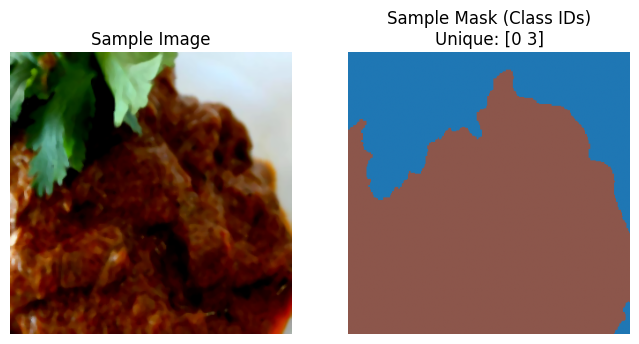

In [ ]:
for sample_images, sample_masks_hw in train_dataset.take(1): 
    print(f"Sample images batch shape: {sample_images.shape}, dtype: {sample_images.dtype}")
    print(f"Sample masks_hw batch shape: {sample_masks_hw.shape}, dtype: {sample_masks_hw.dtype}") 
    mask_to_check = sample_masks_hw[0].numpy()
    unique_vals_in_mask = np.unique(mask_to_check)
    print(f"Mask unique values in first sample: {unique_vals_in_mask}") 
    if True: 
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(sample_images[0].numpy())
        plt.title("Sample Image")
        plt.axis("off")
        plt.subplot(1, 2, 2)
        plt.imshow(mask_to_check, cmap='tab10', vmin=0, vmax=max(1, NUM_MODEL_CLASSES -1))
        plt.title(f"Sample Mask (Class IDs)\nUnique: {unique_vals_in_mask}")
        plt.axis("off")
        plt.show()
    break 

# Model

## Encoder

### CBAM

In [ ]:
class GlobalChannelMeanPool(layers.Layer):
    def __init__(self, **kwargs):
        super(GlobalChannelMeanPool, self).__init__(**kwargs)

    def call(self, inputs):
        return K.mean(inputs, axis=3, keepdims=True)

    def compute_output_shape(self, input_shape):
        return tf.TensorShape([input_shape[0], input_shape[1], input_shape[2], 1])

class GlobalChannelMaxPool(layers.Layer):
    def __init__(self, **kwargs):
        super(GlobalChannelMaxPool, self).__init__(**kwargs)

    def call(self, inputs):
        return K.max(inputs, axis=3, keepdims=True)

    def compute_output_shape(self, input_shape):
        return tf.TensorShape([input_shape[0], input_shape[1], input_shape[2], 1])

In [ ]:
# Modul Channel Attention (CAM) dari CBAM
def channel_attention_module(x, ratio=8, name_prefix=""):
    
    batch, height, width, channels = K.int_shape(x) 
    
    # Squeeze
    avg_pool = GlobalAveragePooling2D(name=f"{name_prefix}_cam_avg_pool")(x)
    max_pool = GlobalMaxPooling2D(name=f"{name_prefix}_cam_max_pool")(x)
    
    # Reshape untuk Dense layer
    avg_pool = Reshape((1, 1, channels), name=f"{name_prefix}_cam_avg_reshape")(avg_pool)
    max_pool = Reshape((1, 1, channels), name=f"{name_prefix}_cam_max_reshape")(max_pool)
    
    # Shared MLP
    # Layer Dense pertama (reduksi)
    dense_shared_1 = Dense(channels // ratio, activation='relu', use_bias=False, name=f"{name_prefix}_cam_mlp_shared_1")
    mlp_avg_1 = dense_shared_1(avg_pool)
    mlp_max_1 = dense_shared_1(max_pool)
    
    # Layer Dense kedua (ekspansi)
    dense_shared_2 = Dense(channels, use_bias=False, name=f"{name_prefix}_cam_mlp_shared_2")
    mlp_avg_2 = dense_shared_2(mlp_avg_1)
    mlp_max_2 = dense_shared_2(mlp_max_1)
    
    # Excitation
    combined_features = Add(name=f"{name_prefix}_cam_add")([mlp_avg_2, mlp_max_2])
    channel_attention_weights = Activation('sigmoid', name=f"{name_prefix}_cam_sigmoid")(combined_features)
    
    # Kalikan bobot perhatian dengan fitur input
    refined_feature = Multiply(name=f"{name_prefix}_cam_multiply")([x, channel_attention_weights])
    return refined_feature

In [ ]:
# Modul Spatial Attention (SAM) dari CBAM
def spatial_attention_module(x, kernel_size=7, name_prefix=""):
    input_shape_tensor = x.shape

    def pooling_output_shape(input_shape_arg): 
        current_input_shape = input_shape_arg 
        if not isinstance(current_input_shape, tf.TensorShape):
            try:
                current_input_shape = tf.TensorShape(current_input_shape)
            except:
                if hasattr(current_input_shape, '__len__') and len(current_input_shape) > 2:
                     return tuple([None] * (len(current_input_shape) - 2) + [1])
                else: 
                    return (None, None, 1)
    
        if current_input_shape.rank == 4: 
            return (current_input_shape[1], current_input_shape[2], 1)
        elif current_input_shape.rank == 3: 
            return (current_input_shape[0], current_input_shape[1], 1)
        else: 
            return (None, None, 1)

    avg_pool = GlobalChannelMeanPool(name=f"{name_prefix}_sam_avg_pool_custom")(x)
    max_pool = GlobalChannelMaxPool(name=f"{name_prefix}_sam_max_pool_custom")(x)
    
    print(f"Shape avg_pool sebelum concat ({name_prefix}): {avg_pool.shape}")
    print(f"Shape max_pool sebelum concat ({name_prefix}): {max_pool.shape}")
    
    concat_features = Concatenate(axis=3, name=f"{name_prefix}_sam_concat")([avg_pool, max_pool])
    
    spatial_attention_map = Conv2D(1, kernel_size, padding='same', activation='sigmoid', 
                                   kernel_initializer='he_normal', use_bias=False, 
                                   name=f"{name_prefix}_sam_conv")(concat_features) 
    
    refined_feature = Multiply(name=f"{name_prefix}_sam_multiply")([x, spatial_attention_map])
    return refined_feature

In [ ]:
# CBAM Block: Channel Attention Module diikuti Spatial Attention Module
def cbam_block(x, ratio=8, kernel_size=7, name=None):
    base_name = name if name else f"cbam_{K.get_uid('cbam_')}"

    x_channel_refined = channel_attention_module(x, ratio=ratio, name_prefix=f"{base_name}_channel")
    x_spatial_refined = spatial_attention_module(x_channel_refined, kernel_size=kernel_size, name_prefix=f"{base_name}_spatial")
    return x_spatial_refined

In [ ]:
def transition_layer(x, filters, name="transition_layer"):
    x = layers.Conv2D(filters, (1, 1), padding='same', activation='relu', name=name)(x)
    x = layers.AveragePooling2D((2, 2), strides=2, padding='same')(x)
    return x

### Encoder Block

In [ ]:
def encoder_os32_10x10(input_tensor, dense_blocks_count=7, cbam_kernel_size=9, cbam_ratio=16):
    skips = []
    
    # Initial Conv + Pool (2x downsampling)
    x = layers.Conv2D(64, (7, 7), strides=2, padding='same', activation='relu', name='enc_os32_conv1')(input_tensor) # 320->160
    x = layers.BatchNormalization(name='enc_os32_bn1')(x)
    skips.append(x) # Skip 0: 160x160

    x = layers.MaxPooling2D((3, 3), strides=2, padding='same', name='enc_os32_pool1')(x) # 160->80
    skips.append(x) # Skip 1: 80x80

    # Tahap 1 (input 80x80 -> output 40x40)
    x = dense_block(x, filters=64, blocks=dense_blocks_count, name="enc_os32_dense_block1") 
    x = transition_layer(x, x.shape[-1] // 2, name="enc_os32_transition1") 
    x = cbam_block(x, ratio=cbam_ratio, kernel_size=cbam_kernel_size, name="enc_os32_cbam1")
    skips.append(x) # Skip 2: 40x40

    # Tahap 2 (input 40x40 -> output 20x20)
    x = dense_block(x, filters=128, blocks=dense_blocks_count, name="enc_os32_dense_block2")
    x = transition_layer(x, x.shape[-1] // 2, name="enc_os32_transition2") 
    x = cbam_block(x, ratio=cbam_ratio, kernel_size=cbam_kernel_size, name="enc_os32_cbam2")
    skips.append(x) # Skip 3: 20x20

    # Tahap 3 (input 20x20 -> output 10x10) (Bottleneck)
    x = dense_block(x, filters=256, blocks=dense_blocks_count, name="enc_os32_dense_block3_bottleneck_in")
    x = transition_layer(x, x.shape[-1] // 2, name="enc_os32_transition3_bottleneck_out") 
    x = cbam_block(x, ratio=cbam_ratio, kernel_size=cbam_kernel_size, name="enc_os32_cbam3_bottleneck_final")
    # 'x' = bottleneck 10x10
    
    # skips = [160, 80, 40, 20]
    print("Encoder OS32 (10x10) - Skip Shapes for Decoder:")
    for i_s, s_item in enumerate(skips):
        print(f"Skip {i_s}: {s_item.shape}")
    print(f"Encoder OS32 (10x10) - Bottleneck Shape: {x.shape}")
    
    return x, skips

## Decoder

In [57]:
def attention_gate(x, g, inter_channels):
    theta_x = Conv2D(inter_channels, (1,1))(x)
    phi_g = Conv2D(inter_channels, (1,1))(g)
    add = Activation('relu')(Add()([theta_x, phi_g]))
    psi = Conv2D(1, (1,1), activation='sigmoid')(add)
    return Multiply()([x, psi])

In [58]:
def crop_to_match(tensors):
    up, skip = tensors
    uh, uw = tf.shape(up)[1], tf.shape(up)[2]
    sh, sw = tf.shape(skip)[1], tf.shape(skip)[2]
    dh, dw = sh - uh, sw - uw
    top, left = dh // 2, dw // 2
    return skip[:, top:top+uh, left:left+uw, :]

In [ ]:
def se_block_decoder(inputs, ratio=8, name=None):
    filters = inputs.shape[-1]
    se = layers.GlobalAveragePooling2D()(inputs)  
    se = layers.Dense(filters // ratio, activation='relu')(se)
    se = layers.Dense(filters, activation='sigmoid')(se)
    se = layers.Reshape((1, 1, filters))(se)      
    return layers.Multiply(name=name)([inputs, se])


### Decoder block

In [ ]:
def decoder_os32_10x10(bottleneck_aspp_input, skips_from_encoder, num_classes, cbam_kernel_size=5, cbam_ratio=8):
    x = bottleneck_aspp_input 

    # Filter untuk 4 tahap upsampling di loop
    decoder_filter_sizes = [256, 128, 64, 32] 

    for i, f_decoder in enumerate(decoder_filter_sizes):
        x = layers.Conv2DTranspose(f_decoder, (3, 3), strides=2, padding='same', activation='relu', name=f"dec_os32_upconv_{i+1}")(x)
        
        skip_index = len(skips_from_encoder) - 1 - i
        skip_connection = skips_from_encoder[skip_index]
        
        skip_connection = Lambda(crop_to_match, name=f"dec_os32_crop_skip_{i+1}")([x, skip_connection])

        att_skip = attention_gate(skip_connection, x, inter_channels=f_decoder // 2)
        x = layers.Concatenate(name=f"dec_os32_concat_skip_{i+1}")([x, att_skip])
        x = cbam_block(x, ratio=cbam_ratio, kernel_size=cbam_kernel_size, name=f"dec_os32_cbam_{i+1}")
        x = layers.Conv2D(f_decoder, (3, 3), padding='same', activation='relu', name=f"dec_os32_conv_after_cbam_{i+1}")(x)
        x = layers.SpatialDropout2D(0.25)(x)

    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation='relu', name="dec_os32_final_upsample_to_target")(x) 
    return x

## Construct Model

In [ ]:
def aspp_module(inputs, num_filters, rates=[6, 12, 18], name_prefix="aspp"):
    dims = K.int_shape(inputs) 
    
    conv_1x1 = layers.Conv2D(num_filters, (1, 1), padding="same", activation="relu", 
                             kernel_regularizer=regularizers.l2(1e-4),
                             name=f"{name_prefix}_conv1x1")(inputs)

    # Atrous Convolutions
    atrous_convs = [conv_1x1] 
    for rate in rates:
        conv_rate = layers.Conv2D(num_filters, (3, 3), padding="same", activation="relu", 
                                  dilation_rate=rate, 
                                  kernel_regularizer=regularizers.l2(1e-4),
                                  name=f"{name_prefix}_dconv_rate{rate}")(inputs)
        atrous_convs.append(conv_rate)

    # Image Pooling
    if dims[1] is not None and dims[2] is not None:
        pool_size = (dims[1], dims[2]) 
        img_pool = layers.AveragePooling2D(pool_size=pool_size, name=f"{name_prefix}_img_pool")(inputs)
        img_pool_conv = layers.Conv2D(num_filters, (1, 1), padding="same", activation="relu",
                                      kernel_regularizer=regularizers.l2(1e-4),
                                      name=f"{name_prefix}_img_pool_conv")(img_pool)
     
        img_pool_upsampled = layers.UpSampling2D(size=(dims[1], dims[2]), interpolation='bilinear', name=f"{name_prefix}_img_pool_upsample_tf_lt_2.4")(img_pool_conv)

        atrous_convs.append(img_pool_upsampled)
    else:
        print("Warning: ASPP input dimensions are None, skipping image pooling branch upsampling.")
    concat = layers.Concatenate(axis=-1, name=f"{name_prefix}_concat")(atrous_convs)
    
    output = layers.Conv2D(num_filters, (1, 1), padding="same", activation="relu",
                           kernel_regularizer=regularizers.l2(1e-4),
                           name=f"{name_prefix}_output_conv")(concat)
    output = layers.SpatialDropout2D(0.25, name=f"{name_prefix}_dropout")(output)
    return output

In [ ]:
def build_unet_densenet_encoder(input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3), num_classes=NUM_MODEL_CLASSES):
    inputs = Input(shape=input_shape)

    encoder_output, skips = encoder_os32_10x10(inputs)
    bottleneck_aspp = aspp_module(encoder_output, num_filters=256, rates=[3, 6, 9], name_prefix="aspp_bottleneck")
    x = decoder_os32_10x10(bottleneck_aspp, skips, num_classes)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu', name="decoder_refine_1")(x)

    x = layers.BatchNormalization(name="decoder_refine_bn_1")(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu', name="decoder_refine_2")(x)

    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax', name="output_layer")(x)


    return models.Model(inputs, outputs, name="DenseNet_Encoder_UNet")


## Build Model

In [64]:
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

In [ ]:
# COMBINE LOSS

def dice_loss_sparse_multiclass_from_probs(y_true_sparse, y_pred_prob, smooth=1e-6): 
    y_true_one_hot = tf.one_hot(tf.cast(y_true_sparse, tf.int32), depth=NUM_MODEL_CLASSES, axis=-1)
    
    axes_to_reduce = [1, 2] 
    intersection = tf.reduce_sum(y_true_one_hot * y_pred_prob, axis=axes_to_reduce) 
    sum_true = tf.reduce_sum(y_true_one_hot, axis=axes_to_reduce) 
    sum_pred = tf.reduce_sum(y_pred_prob, axis=axes_to_reduce) 
    
    dice_per_sample_per_class = (2. * intersection + smooth) / (sum_true + sum_pred + smooth) 
    
    mean_dice_per_class = tf.reduce_mean(dice_per_sample_per_class, axis=0) 
    mean_dice_overall = tf.reduce_mean(mean_dice_per_class) 
    
    return 1 - mean_dice_overall

def combined_loss_multiclass_sparse_from_probs(alpha=0.7, beta=0.3):
    scc_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    def loss(y_true_sparse, y_pred_prob): 
        scc = scc_loss_fn(y_true_sparse, y_pred_prob)
        dice = dice_loss_sparse_multiclass_from_probs(y_true_sparse, y_pred_prob)
        return alpha * scc + beta * dice
    return loss

In [ ]:
class MeanIoUAdapted(tf.keras.metrics.Metric):
    def __init__(self, num_classes_metric, name='mean_iou_adapted', **kwargs):
        super(MeanIoUAdapted, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes_metric
        self.total_cm = self.add_weight(
            name='total_confusion_matrix',
            shape=(self.num_classes, self.num_classes),
            initializer='zeros',
            dtype=tf.int64
        )

    def update_state(self, y_true_sparse, y_pred_input, sample_weight=None): 
        
        y_pred_labels = tf.argmax(y_pred_input, axis=-1, output_type=tf.int32)
        y_true_labels = tf.cast(y_true_sparse, dtype=tf.int32)

        y_true_flat = tf.reshape(y_true_labels, [-1])
        y_pred_flat = tf.reshape(y_pred_labels, [-1])

        current_cm = tf.math.confusion_matrix(
            labels=y_true_flat,
            predictions=y_pred_flat,
            num_classes=self.num_classes,
            dtype=self.total_cm.dtype
        )
        self.total_cm.assign_add(tf.cast(current_cm, self.total_cm.dtype))

    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=tf.float32)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=tf.float32)
        true_positives = tf.cast(tf.linalg.tensor_diag_part(self.total_cm), dtype=tf.float32)

        denominator = sum_over_row + sum_over_col - true_positives
        iou_per_class = true_positives / (denominator + tf.keras.backend.epsilon())
        
        valid_iou_mask = tf.math.greater(denominator, 0.0)
        iou_per_class_valid = tf.where(valid_iou_mask, iou_per_class, tf.zeros_like(iou_per_class))
        
        num_valid_classes = tf.reduce_sum(tf.cast(valid_iou_mask, tf.float32))
        mean_iou = tf.reduce_sum(iou_per_class_valid) / (num_valid_classes + tf.keras.backend.epsilon())
        return mean_iou

    def reset_states(self):
        self.total_cm.assign(tf.zeros_like(self.total_cm))

In [67]:
model = build_unet_densenet_encoder(
    input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3),
    num_classes=NUM_MODEL_CLASSES
)
model.summary()

Shape avg_pool sebelum concat (enc_os32_cbam1_spatial): (None, 40, 40, 1)
Shape max_pool sebelum concat (enc_os32_cbam1_spatial): (None, 40, 40, 1)
Shape avg_pool sebelum concat (enc_os32_cbam2_spatial): (None, 20, 20, 1)
Shape max_pool sebelum concat (enc_os32_cbam2_spatial): (None, 20, 20, 1)
Shape avg_pool sebelum concat (enc_os32_cbam3_bottleneck_final_spatial): (None, 10, 10, 1)
Shape max_pool sebelum concat (enc_os32_cbam3_bottleneck_final_spatial): (None, 10, 10, 1)
Encoder OS32 (10x10) - Skip Shapes for Decoder:
Skip 0: (None, 160, 160, 64)
Skip 1: (None, 80, 80, 64)
Skip 2: (None, 40, 40, 256)
Skip 3: (None, 20, 20, 576)
Encoder OS32 (10x10) - Bottleneck Shape: (None, 10, 10, 1184)
Shape avg_pool sebelum concat (dec_os32_cbam_1_spatial): (None, 20, 20, 1)
Shape max_pool sebelum concat (dec_os32_cbam_1_spatial): (None, 20, 20, 1)
Shape avg_pool sebelum concat (dec_os32_cbam_2_spatial): (None, 40, 40, 1)
Shape max_pool sebelum concat (dec_os32_cbam_2_spatial): (None, 40, 40, 1)


Model: "DenseNet_Encoder_UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 320, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_conv1      │ (None, 160, 160,  │      9,472 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_bn1        │ (None, 160, 160,  │        256 │ enc_os32_conv1[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_pool1      │ (None, 80, 80,    │          0 │ enc_os32_bn1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │        256 │ enc_os32_pool1[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │          0 │ enc_os32_dense_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │      1,040 │ enc_os32_dense_b… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 80, 80,    │          0 │ enc_os32_dense_b… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │         64 │ dropout[0][0]     │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │          0 │ enc_os32_dense_b… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │      9,280 │ enc_os32_dense_b… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 80, 80,    │          0 │ enc_os32_dense_b… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │          0 │ enc_os32_pool1[0… │
│ (Concatenate)       │ 128)              │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │        512 │ enc_os32_dense_b… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │          0 │ enc_os32_dense_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_os32_dense_blo… │ (None, 80, 80,    │      2,064 │ enc_os32_dense_b… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 80, 80,    │          0 │ enc_os32_dense_b

 Total params: 19,038,905 (72.63 MB)

 Trainable params: 19,005,721 (72.50 MB)

 Non-trainable params: 33,184 (129.62 KB)

## Train Model

In [69]:
val_images = []
val_masks = []
for img, mask in test_dataset:
    val_images.append(img.numpy())
    val_masks.append(mask.numpy())
val_images = np.concatenate(val_images, axis=0)
val_masks = np.concatenate(val_masks, axis=0)

2025-06-02 20:36:58.635358: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou_adapted', 
    factor=0.5, 
    patience=50,
    verbose=0,
    mode='max', 
    min_lr=0.0000001
)

In [73]:
mean_iou_metric = MeanIoUAdapted(num_classes_metric=NUM_MODEL_CLASSES)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=combined_loss_multiclass_sparse_from_probs(alpha=0.5, beta=0.5), 
    metrics=['accuracy', mean_iou_metric] 
)

In [ ]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=500,
    callbacks=[
        reduce_lr_on_plateau,
    ],    
)

Epoch 1/500


I0000 00:00:1748871442.814187 2269199 service.cc:152] XLA service 0x7f2b100025b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748871442.814320 2269199 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2025-06-02 20:37:24.099076: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-06-02 20:37:25.893098: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-02 20:37:25.894902: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
2025-06-02 20:37:25.896255: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operato

 1/50 ━━━━━━━━━━━━━━━━━━━━ 1:13:39 90s/step - accuracy: 0.1771 - loss: 1.9425 - mean_iou_adapted: 0.0613

I0000 00:00:1748871508.740113 2269199 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.3758 - loss: 1.6765 - mean_iou_adapted: 0.1184

2025-06-02 20:38:36.218328: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-02 20:38:36.219154: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
2025-06-02 20:38:36.219903: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
2025-06-02 20:38:36.221062: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less/Assert/AssertGuard/Assert
2025-06-02 20:38:36.221967: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less_1/Assert/AssertGuard/Assert


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3768 - loss: 1.6729 - mean_iou_adapted: 0.1188   

2025-06-02 20:39:23.553061: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-06-02 20:39:23.554740: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative/assert_less_equal/Assert/AssertGuard/Assert
2025-06-02 20:39:23.555961: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_non_negative_1/assert_less_equal/Assert/AssertGuard/Assert
2025-06-02 20:39:23.557739: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less/Assert/AssertGuard/Assert
2025-06-02 20:39:23.559155: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator confusion_matrix/assert_less_1/Assert/AssertGuard/Assert
2025-06-02 20:39:30.295816: W tensorflow/compiler/tf2xla/kernels/assert_op

50/50 ━━━━━━━━━━━━━━━━━━━━ 158s 1s/step - accuracy: 0.3777 - loss: 1.6695 - mean_iou_adapted: 0.1191 - val_accuracy: 0.5289 - val_loss: 1.5379 - val_mean_iou_adapted: 0.0756 - learning_rate: 5.0000e-04
Epoch 2/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 0.4929 - loss: 1.1811 - mean_iou_adapted: 0.1700 - val_accuracy: 0.5289 - val_loss: 1.4426 - val_mean_iou_adapted: 0.0756 - learning_rate: 5.0000e-04
Epoch 3/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.5050 - loss: 1.1057 - mean_iou_adapted: 0.2046 - val_accuracy: 0.5289 - val_loss: 1.4011 - val_mean_iou_adapted: 0.0756 - learning_rate: 5.0000e-04
Epoch 4/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.4876 - loss: 1.0878 - mean_iou_adapted: 0.1900 - val_accuracy: 0.5213 - val_loss: 1.3861 - val_mean_iou_adapted: 0.1124 - learning_rate: 5.0000e-04
Epoch 5/500
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.5088 - loss: 1.0591 - mean_iou_adapted: 0.2106 - val_accuracy: 0.5403 - val_loss: 1.33

In [96]:
test_loss, test_accuracy, test_miou = model.evaluate(val_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test mIoU: {test_miou:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 484ms/step - accuracy: 0.9164 - loss: 0.5039 - mean_iou_adapted: 0.8027
Test Loss: 0.4985
Test Accuracy: 0.9172
Test mIoU: 0.8080


In [76]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_miou = history.history['mean_iou_adapted'] 
val_miou = history.history['val_mean_iou_adapted'] 
lr_hist = history.history['learning_rate'] 

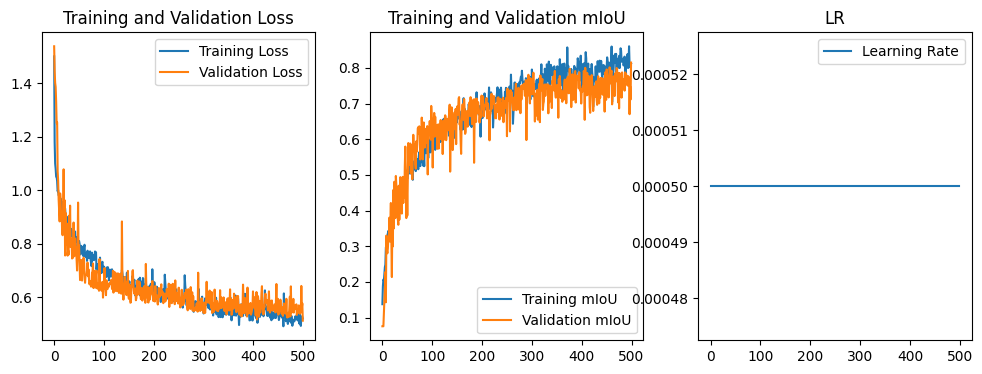

In [ ]:
epochs_range = range(len(train_loss)) 

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_miou, label='Training mIoU')
plt.plot(epochs_range, val_miou, label='Validation mIoU')
plt.legend(loc='lower right')
plt.title('Training and Validation mIoU')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, lr_hist, label='Learning Rate')
plt.legend(loc='upper right')
plt.title('LR')

plt.show()

In [108]:
import pandas as pd
import pandas as pd

history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index + 1
history_df.to_csv("training_log_miou_0.8148.csv", index=False)

serializable_history = {k: [float(val) for val in v] for k, v in history.history.items()}
with open("training_log_miou_0.8148.json", 'w') as f:
    json.dump(serializable_history, f, indent=4)

In [109]:
coba = pd.read_csv("training_log_miou_0.8148.csv")
coba

,accuracy,loss,mean_iou_adapted,val_accuracy,val_loss,val_mean_iou_adapted,learning_rate,epoch
0,0.424445,1.500234,0.137459,0.528900,1.537854,0.075557,0.0005,1
1,0.470871,1.179650,0.187591,0.528900,1.442632,0.075557,0.0005,2
2,0.501439,1.099862,0.206572,0.528900,1.401080,0.075557,0.0005,3
3,0.499748,1.080085,0.203152,0.521256,1.386069,0.112360,0.0005,4
4,0.516919,1.050726,0.221800,0.540334,1.330850,0.148359,0.0005,5
...,...,...,...,...,...,...,...,...
495,0.927934,0.493016,0.860415,0.898223,0.542858,0.773253,0.0005,496
496,0.907331,0.523037,0.809290,0.830772,0.642249,0.670045,0.0005,497
497,0.903116,0.528629,0.801425,0.878810,0.560241,0.748521,0.0005,498
498,0.907871,0.526634,0.810850,0.869348,0.577146,0.711108,0.0005,499


# Fine Tune

In [ ]:
model_path_h5 = "model_dense_unet.h5"

custom_objects_dict = {
    'crop_to_match': crop_to_match,
    'GlobalChannelMeanPool': GlobalChannelMeanPool,
    'GlobalChannelMaxPool': GlobalChannelMaxPool,
    'channel_attention_module': channel_attention_module,
    'spatial_attention_module': spatial_attention_module,
    'cbam_block': cbam_block
}

try:
    model_h5 = tf.keras.models.load_model(
        model_path_h5,
        custom_objects=custom_objects_dict,
        compile=False 
    )
except Exception as e:
    print(f"Error loading .h5 model: {e}")
    import traceback
    traceback.print_exc()

Model .h5 loaded successfully!


In [ ]:
reduce_lr_fine_tune = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou_adapted',
    factor=0.7,  
    patience=10, 
    mode='max',
    min_lr=1e-10,
    verbose=1
)

In [101]:
FINE_TUNE_LR = 1e-7

In [102]:
optimizer_fine_tune = tf.keras.optimizers.Adam(learning_rate=FINE_TUNE_LR)

In [103]:
model_h5.compile(
    optimizer=optimizer_fine_tune,
    loss=combined_loss_multiclass_sparse_from_probs(alpha=0.5, beta=0.5), 
    metrics=['accuracy', mean_iou_metric] 
)

In [104]:
NUM_FINE_TUNE_EPOCHS = 100

In [106]:
history_fine_tune = model_h5.fit(
    train_dataset,             
    validation_data=test_dataset, 
    epochs=NUM_FINE_TUNE_EPOCHS,
    callbacks=[
        reduce_lr_fine_tune
    ]
)

Epoch 1/100


2025-06-03 11:08:51.733746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_multiply_reduce_fusion_12', 136 bytes spill stores, 108 bytes spill loads



50/50 ━━━━━━━━━━━━━━━━━━━━ 136s 1s/step - accuracy: 0.9201 - loss: 0.4964 - mean_iou_adapted: 0.8217 - val_accuracy: 0.9130 - val_loss: 0.5114 - val_mean_iou_adapted: 0.8090 - learning_rate: 1.0000e-07
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9127 - loss: 0.5069 - mean_iou_adapted: 0.8145 - val_accuracy: 0.9130 - val_loss: 0.5115 - val_mean_iou_adapted: 0.8089 - learning_rate: 1.0000e-07
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9244 - loss: 0.4923 - mean_iou_adapted: 0.8444 - val_accuracy: 0.9130 - val_loss: 0.5112 - val_mean_iou_adapted: 0.8086 - learning_rate: 1.0000e-07
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step - accuracy: 0.9198 - loss: 0.4959 - mean_iou_adapted: 0.8319 - val_accuracy: 0.9126 - val_loss: 0.5119 - val_mean_iou_adapted: 0.8077 - learning_rate: 1.0000e-07
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9283 - loss: 0.4807 - mean_iou_adapted: 0.8489 - val_accuracy: 0.9126 - val_loss: 0.51